In [7]:
import torch
from torchvision.models import resnet50
from torchvision import transforms
from collections import OrderedDict
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from PIL import Image

In [8]:
checkpoint_path = 'resnet50_weights_best_acc.tar'  # Path to the PyTorch checkpoint file
dir_path = 'models/'
num_classes = 1081  # Number of classes for the Pl@ntNet-300K dataset

model = resnet50(num_classes=num_classes)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Keep all layers except the last one

# Load the checkpoint
try:
    checkpoint = torch.load(dir_path + checkpoint_path, map_location='cpu')
    state_dict = checkpoint.get('state_dict', checkpoint)  # Use 'state_dict' if it exists, otherwise the checkpoint itself

    # Adjust state_dict keys if necessary (e.g., remove 'module.' prefix)
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace('module.', '')  # Adjust this as needed based on the key inspection
        new_state_dict[new_key] = v

    # Load the adjusted state_dict into the model
    model.load_state_dict(new_state_dict, strict=False)
    print("Checkpoint loaded successfully.")
except Exception as e:
    print(f"Error loading checkpoint: {e}")
    exit(1)

Checkpoint loaded successfully.


C:\Users\aaron\AppData\Local\Temp\ipykernel_19576\3141227564.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(dir_path + checkpoint_path, map_loc

In [9]:
def load_class_labels(label_path):
    """
    Load class labels from a JSON file.
    """
    with open(label_path, 'r') as f:
        labels = json.load(f)  # Assuming the labels are stored in a list format
    return labels

In [10]:
def extract_features(model, input_tensor):
    """
    Extract features from the input tensor using the encoder part of the model.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        features = model(input_tensor)  # Get features from the encoder
    return features

In [11]:
def preprocess_image(image):
    """
    Preprocess the input image for ResNet-50.
    """
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image)


In [12]:
# Load class labels (if needed for a specific task)
label_path = 'plantnet300K_species_id_2_name.json'  # Path to your JSON file with labels
class_labels = load_class_labels(label_path)

# Load and preprocess the image
dir_path = "frames/"
files = os.listdir(dir_path)
print(f"Total amount of frames: {len(files)}")

json_file_path = "embeddings.json"
json_data = []

embeddings = []

for i, frame in enumerate(files):
    frame = Image.open(dir_path + frame)  # Load the image
    preprocessed_image = preprocess_image(frame)  # Preprocess the image
    input_tensor = preprocessed_image.unsqueeze(0)  # Shape (1, 3, 224, 224) so only 1 images goes trough the network
    features = extract_features(model, input_tensor)
    print(len(features.cpu().numpy().flatten()))
    
    # write to json
    data = {
        "filename": f"frame{i}.jpg",
        "feature": features.cpu().numpy().flatten().tolist()
    }
    json_data.append(data)
    
    embeddings.append(features.cpu().numpy().flatten())

with open(json_file_path, 'w') as json_file:
    json.dump(json_data, json_file, indent=4)  # Write with pretty printing


embeddings = np.array(embeddings)

FileNotFoundError: [Errno 2] No such file or directory: 'plantnet300K_species_id_2_name.json'

In [ ]:
print(len(embeddings))
print(embeddings[0])

56
[8.5670042e-01 4.2832634e+01 4.6320816e+01 ... 2.0228304e-02 7.4118428e+00
 3.8385658e+01]


In [ ]:
def load_img(img_path, target_size=None):
    """Load and resize an image."""
    img = Image.open(img_path)
    if target_size:
        img = img.resize(target_size)
    return np.array(img)  # Convert to a numpy array for matplotlib

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np

def visualize_embeddings(embeddings):
    # Create a scatter plot
    plt.figure(figsize=(10, 8))

    # Loop through each point and add the corresponding thumbnail
    for idx, point in enumerate(embeddings):
        x, y = point[0], point[1]
        
        plt.scatter(x, y, alpha=0)  # Hide the original points
        
        # Load and create thumbnail for the image
        img = load_img(os.path.join(dir_path, files[idx]), target_size=(50, 50))  # Resize thumbnail
        imagebox = OffsetImage(img, zoom=0.8)  # Adjust zoom as needed
        
        # Create an annotation box with the thumbnail
        ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0.1)
        
        # Add the annotation box to the plot
        plt.gca().add_artist(ab)

    plt.title("Image Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.autoscale(True)
    plt.grid()
    plt.show()


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=25, random_state=42, max_iter=1000)

In [ ]:
tsne_result = tsne.fit_transform(embeddings)
pca_results = pca.fit_transform(embeddings)

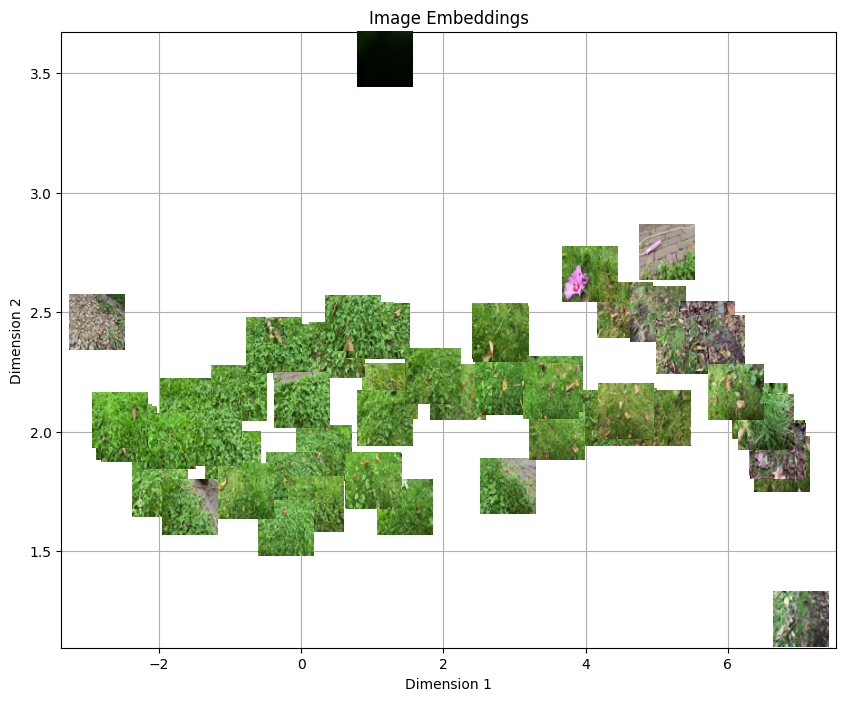

In [ ]:
visualize_embeddings(tsne_result)

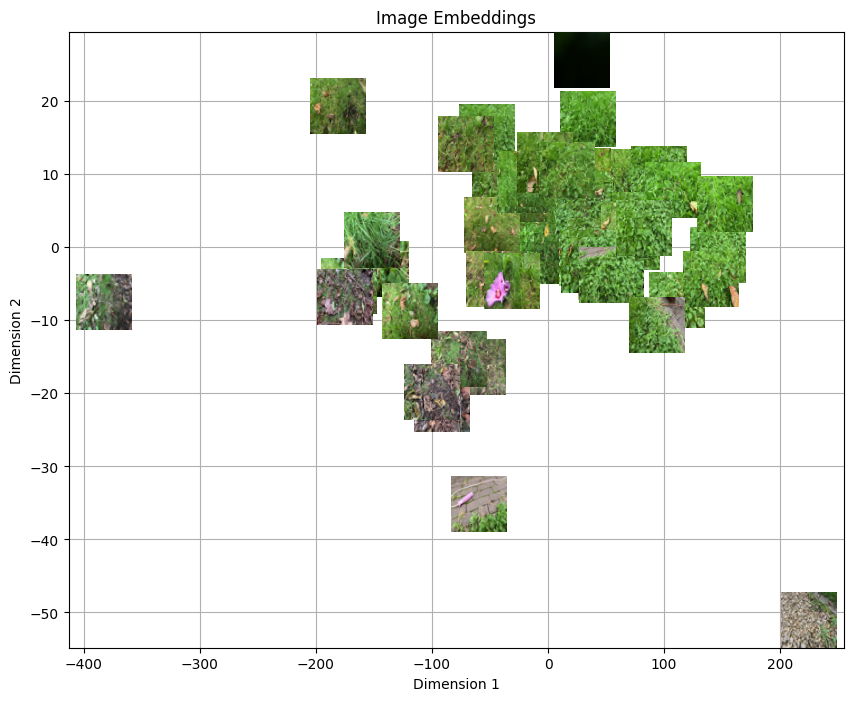

In [ ]:
visualize_embeddings(pca_results)

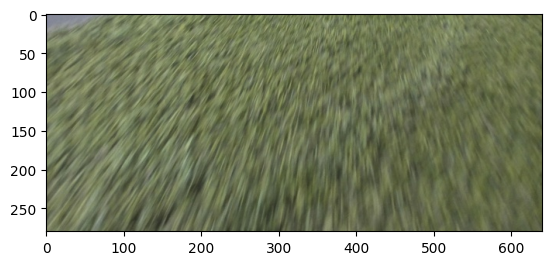

In [ ]:
# read image
img = Image.open("frames/9.jpg")
width, height = img.size
img = img.crop((0, 200, width, height)) # upper left corner, lower right corner
plt.imshow(img)

In [13]:
def crop_image(image):
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    cropped_img = img[200:,:] # Crop the image
    plt.imshow(cropped_img)
    

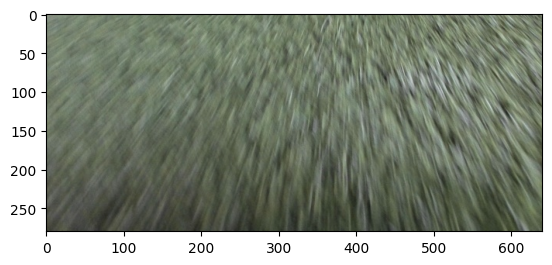

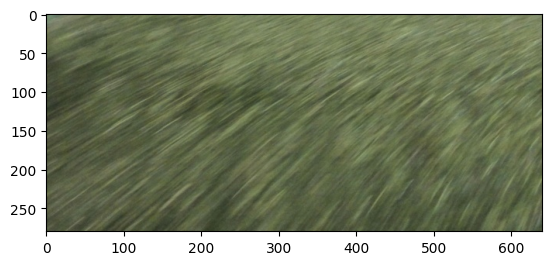

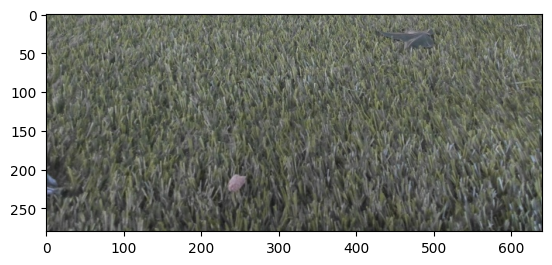

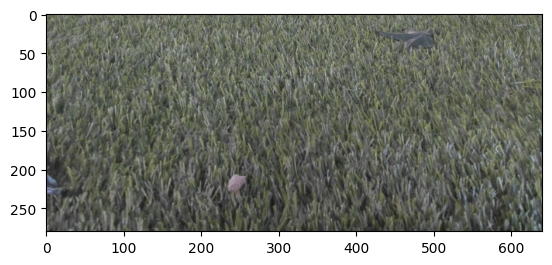

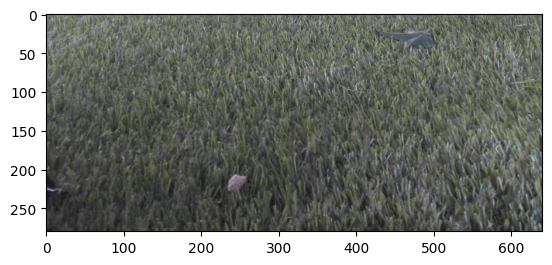

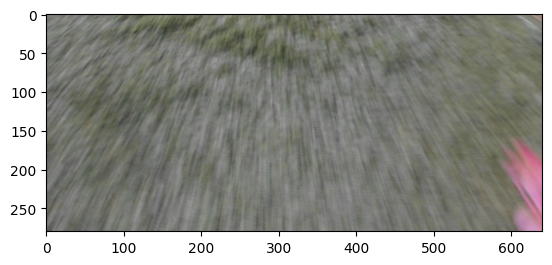

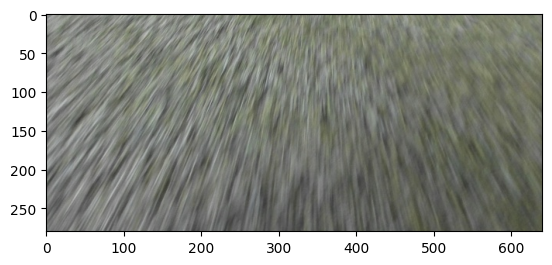

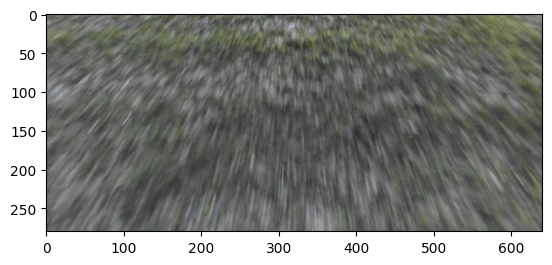

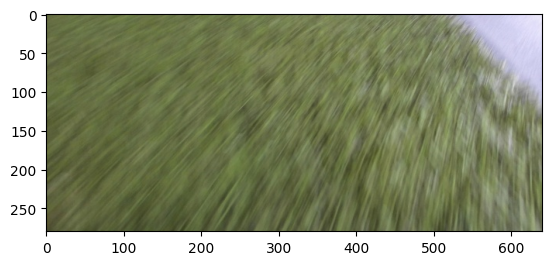

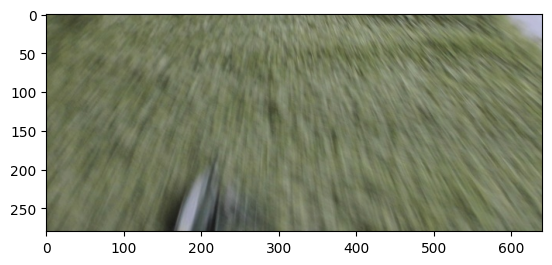

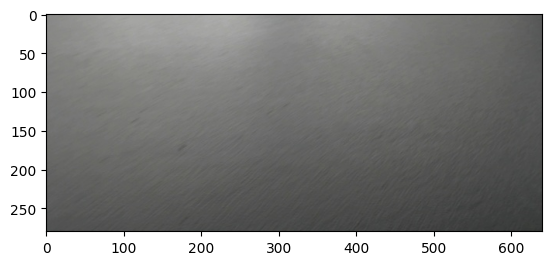

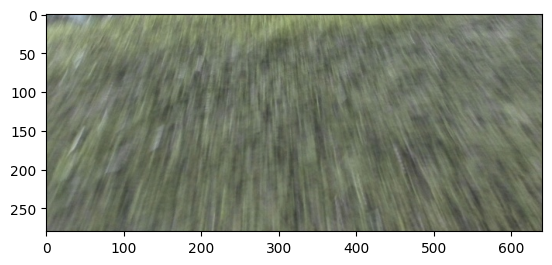

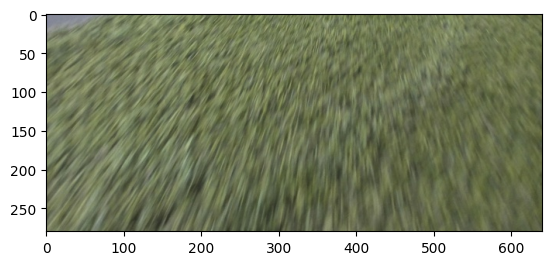

In [14]:
# list dir
files = os.listdir("frames/")
for image in files:
    crop_image("frames/" + image)
    plt.show()